In [14]:
import glob
from PIL import Image
import numpy as np
import sparse
from matplotlib import cm
from tqdm.notebook import tqdm, tnrange
from IPython.display import display

In [15]:
# Parameters

z_r = 17.0
z_a = 6.5
z_b = 15.0
z_f = 20.0

display_depths = np.array([z_a, z_b])[:, None]

pupil_diameter = 5.0
retina_size = np.array([5.5, 5.5])
display_size = retina_size[None] * display_depths / abs(z_r)

retina_resolution = np.array([128, 128])
low_resolution = np.array([[8, 8], [16, 16]])
high_resolution = np.array([[16, 16], [32, 32]])

In [16]:
# Anti-aliased circle generation functions

def semicircle(x):
    return np.sqrt(1.0 - np.square(x))

def semicircle_integral(x):
    return (np.sqrt(1.0 - np.square(x)) * x + np.arcsin(x))/2

def semicircle_box_area(x_bounds, y_bounds):
    y_bounds = np.clip(y_bounds, 0.0, 1.0)

    x_bounds = np.repeat(x_bounds[..., None, :], 2, axis=-2)
    y_bounds = np.repeat(y_bounds[..., :, None], 2, axis=-1)

    h_bounds = semicircle(y_bounds)
    x_bounds = np.clip(x_bounds, -h_bounds, h_bounds)

    return np.tensordot(semicircle_integral(x_bounds) - x_bounds * y_bounds, [[-1.0, 1.0], [1.0, -1.0]], axes=2)

def circle_box_area(box_bounds):
    x_bounds, y_bounds = np.moveaxis(box_bounds, -1, 0)
    upper_semicircle = semicircle_box_area(x_bounds, y_bounds)
    lower_semicircle = semicircle_box_area(x_bounds, -np.flip(y_bounds, -1))
    return upper_semicircle + lower_semicircle

In [17]:
# Index and coordinate manipulation functions

def create_index_array(resolution):
  shape = (*resolution.flat, *resolution.shape)
  return np.moveaxis(np.mgrid[[slice(i) for i in resolution.flat]], 0, -1).reshape(shape)

def index_to_coord(indices, resolution, size):
  pitch = size / resolution
  return (indices - (resolution - 1)/2) * pitch

def coord_to_index(coords, resolution, size):
  pitch = size / resolution
  return coords / pitch + (resolution - 1)/2

def index_to_bounds(indices, resolution, size):
  pitch = size / resolution
  lower_bounds = indices * pitch - size/2
  upper_bounds = lower_bounds + pitch
  return np.stack([lower_bounds, upper_bounds], axis=-2)

In [18]:
# Tensor generation functions

def create_imaging_tensor(retina_resolution, retina_size, display_resolution, display_size,
                          pupil_diameter, z_r, z_f, display_depths):
    tensor_shape = (*retina_resolution, *display_resolution.flat)
    imaging_tensor = sparse.COO([], shape=tensor_shape)

    retina_indices = create_index_array(retina_resolution)
    retina_coords = index_to_coord(retina_indices, retina_resolution, retina_size)
    retina_coords_at_display = retina_coords[..., None, None, :] * display_depths[:, None] / z_r

    display_indices = create_index_array(display_resolution)
    display_bounds = index_to_bounds(display_indices, display_resolution, display_size)

    for i_r, j_r in tqdm(retina_indices.reshape(-1, 2)):
        projected_bounds = (display_bounds - retina_coords_at_display[i_r, j_r]) / (1.0 - display_depths[:, None] / z_f)
        intersection_bounds = np.clip(projected_bounds[..., 0, :, :], projected_bounds[..., 1, 0, None, :],
                                                                      projected_bounds[..., 1, 1, None, :])
        areas = circle_box_area(intersection_bounds / pupil_diameter)
        i_a, j_a, i_b, j_b = areas.nonzero()
        sparse_indices = np.vstack(np.broadcast_arrays(i_r, j_r, i_a, j_a, i_b, j_b))
        sparse_values = areas[(i_a, j_a, i_b, j_b)]
        imaging_tensor += sparse.COO(sparse_indices, sparse_values, shape=tensor_shape)
    return imaging_tensor

In [19]:
# Light field downsampling functions

def naive_downsampling(light_field, resolution):
  resolution = resolution.flatten()
  indices = create_index_array(resolution)
  shifted = indices - (resolution/2).astype(np.int)
  lpf_mask = np.moveaxis(np.fft.ifftshift(shifted, axes=range(len(resolution))), -1, 0)
  spectrum = np.fft.fftn(light_field)
  downsampled = np.real(np.fft.ifftn(spectrum[tuple(lpf_mask)]))
  return downsampled / np.amax(downsampled)

In [20]:
# Image and light field visualization functions

def display_image(values, color_map=None):
  color_values = cm.get_cmap(color_map)(values/np.amax(values))
  uint8_values = (color_values * 255).astype(np.uint8)
  display(Image.fromarray(uint8_values).transpose(Image.ROTATE_90))

def display_light_field(light_field, color_map=None):
    tiled_light_field = light_field.swapaxes(1, 2).reshape((np.prod(light_field.shape[0::2]), -1))
    display_image(tiled_light_field, color_map)

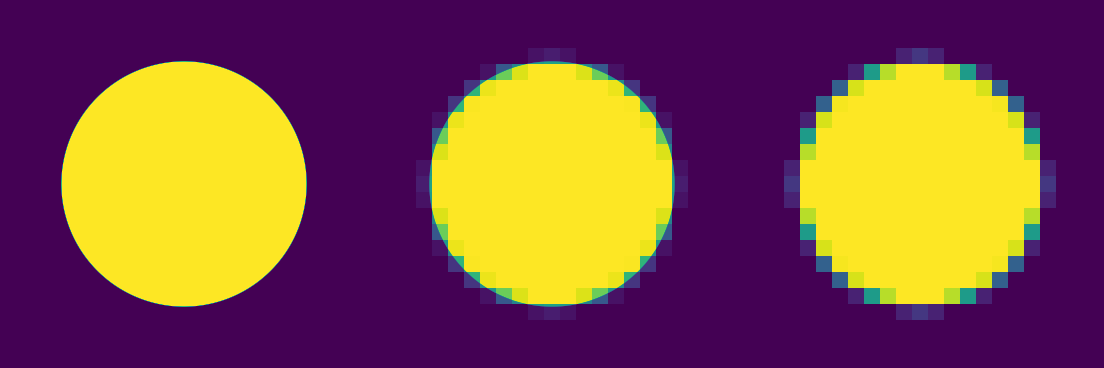

In [21]:
# Anti-aliased circle generation test

test_resolution = np.array([23, 23])
test_size = np.array([3, 3])

pixel_indices = create_index_array(test_resolution*16)
pixel_bounds = index_to_bounds(pixel_indices, test_resolution*16, test_size)
hd_image = circle_box_area(pixel_bounds)

pixel_indices = create_index_array(test_resolution)
pixel_bounds = index_to_bounds(pixel_indices, test_resolution, test_size)
ld_image = np.kron(circle_box_area(pixel_bounds), np.ones((16, 16)) / 16**2)

display_image(np.array([*hd_image, *(hd_image + ld_image)*0.5, *ld_image]))

In [22]:
high_res_tensor = create_imaging_tensor(retina_resolution, retina_size, high_resolution, display_size,
                                        pupil_diameter, z_r, z_f, display_depths)

print('High resolution tensor:', high_res_tensor)
print('Size: {:.2f} GiB'.format(high_res_tensor.nbytes / 10**9))


High resolution tensor: <COO: shape=(128, 128, 16, 16, 32, 32), dtype=float64, nnz=7322436, fill_value=0.0>
Size: 0.41 GiB


In [23]:
low_res_tensor = create_imaging_tensor(retina_resolution, retina_size, low_resolution, display_size,
                                       pupil_diameter, z_r, z_f, display_depths)

print('Low resolution tensor:', low_res_tensor)
print('Size: {:.2f} GiB'.format(low_res_tensor.nbytes / 10**9))


Low resolution tensor: <COO: shape=(128, 128, 8, 8, 16, 16), dtype=float64, nnz=1827904, fill_value=0.0>
Size: 0.10 GiB


In [24]:
dataset_lf = np.zeros((17, 17, 1024, 1024))

dataset_path = "datasets/tarot/"
path_length = len(dataset_path)

for image_path in tqdm(glob.glob(dataset_path + "*.png")):
    i_a = int(image_path[path_length+7:path_length+9])
    j_a = int(image_path[path_length+4:path_length+6])
    dataset_lf[i_a, j_a] = np.array(Image.open(image_path).convert('L').transpose(Image.ROTATE_270))

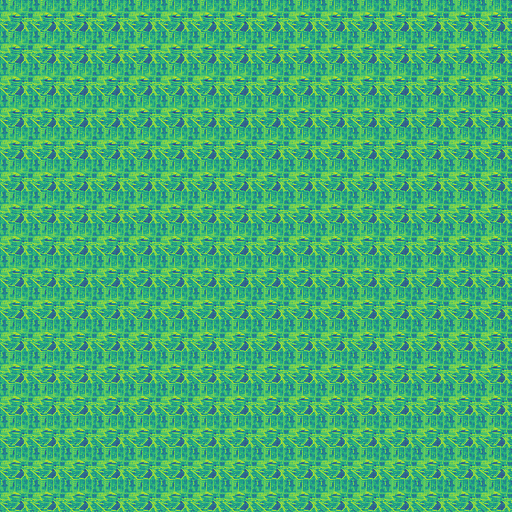

In [25]:
high_res_lf = naive_downsampling(dataset_lf, high_resolution)
display_light_field(high_res_lf)

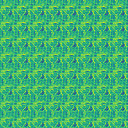

In [26]:
low_res_lf = naive_downsampling(high_res_lf, low_resolution)
display_light_field(low_res_lf)

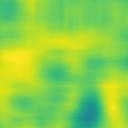

In [27]:
high_res_image = sparse.tensordot(high_res_tensor, high_res_lf, 4)
display_image(high_res_image)

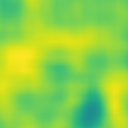

In [28]:
low_res_image = sparse.tensordot(low_res_tensor, low_res_lf, 4)
display_image(low_res_image)